# Tutorial 5.3: Bistability and Oscillations from Two LIF Neurons
## Neuroscience goals:
- learn how cross-inhibition produces either oscillations or bistability in a single circuit, depending on synaptic properties
    - i.e., circuit structure does not determine behavior or function
- observe how noise can produce transitions between activity states
## Computational goals:
- keep track of two modeled neurons and be careful to use the output of one as the input of the other
- record and plot the distribution of durations of states
### Overview
- will couple two LIF neurons with inhibitory synapses
- will see that if inhibition is strong enough, only one neuron can fire
    - as it fires, suppresses any activity in other neuron
- if add noise, random switches in the active neuron arise
- will see that adding short-term synaptic depression generates oscillations whose regularity is affected by strength of noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

- set up simulation to solve LIF equations for the membrane potentials, v_1, and v_2 of the two neurons
    - with synaptic gating variables s1, s2, and depression variables d1, d2:

    $C\frac{dV_1}{dt} = \frac{E - V_1}{R} + G_{21}s{2}(E_{21}^{rev} - V_1) + I_1^{app} + \sigma \cdot \eta(t), \frac{ds_1}{dt} = \frac{-s_1}{\tau_{syn}}, 
    \frac{dD_1}{dt}=\frac{1-D_1}{\tau_D}$

    $C\frac{dV_2}{dt} = \frac{E - V_2}{R} + G_{12}s{1}(E_{12}^{rev} - V_2) + I_2^{app} + \sigma \cdot \eta(t), \frac{ds_2}{dt} = \frac{-s_2}{\tau_{syn}}, 
    \frac{dD_2}{dt}=\frac{1-D_2}{\tau_D}$

- $G_{12}$ and {E_{12}^{rev}}$ denote maximal conductance and reversal potential respectively, of synapse from cell 1 -> 2
- $G_{21}$ and {E_{21}^{rev}}$ denote maximal conductance and reversal potential respectively, of synapse from cell 2 -> 1
- $\eta(t)$ are white noise terms of unit standard deviation
- $\sigma$ is the amplitude of noise
- $I_{app}$ are the applied currents to each cell, including a constant baseline term and a transient term to cause a switch

- spikes are stimulated as follows:

    if $V_1 > V_{th}$ then: $V_1 = V_R, s_1 \mapsto s_1 + p_RD_1(1 - s_1)$ and $D_1 \mapsto D_1(1 - P_R)$
    
    if $V_2 > V_{th}$ then: $V_2 = V_R, s_2 \mapsto s_2 + p_RD_2(1 - s_2)$ and $D_2 \mapsto D_2(1 - P_R)$


### Part A: bistability with no synaptic depression
### i
- c_membrane = 1nF
- r_memrane = 10mOmega
- e_leak = -70mV
- v_threshold = -54mV
- v_reset = -80mV
- synapses are identical and inhibitory
- $E_{12}^{rev} = E_{21}^{rev}$ = -70mV
- $G_{12} = G_{21}$ = 1us
- $\tau_{syn}$ = 10ms
- baseline $I_{app}$ = 2nA
- $p_R$ = 1
- $D_1 = D_2 = 1$ to remove effects of synaptic depression


In [38]:
def reset_params(s=0):
    global c_membrane, r_membrane, e_leak, v_threshold, v_reset,erev_12, erev_21, g_12, g_21, tau_syn, i_app_baseline, p_R, d1, d2, sigma

    c_membrane = 1e-9
    r_membrane = 1e7
    e_leak = -70e-3
    v_threshold = -54e-3
    v_reset = -80e-3
    erev_12 = erev_21 = -70e-3
    g_12 = g_21 = 1e-6
    tau_syn = 10e-3
    i_app_baseline = 2e-9
    p_R = 1
    d1 = d2 = 1
    sigma = s

reset_params()

### ii
- simulate the two coupled neurons for a total time of 6s
- with an extra 3 nA of applied current to one cell for the first 100ms of the simulation
- then a pulse of 3nA to the other cell for 100ms at the midpoint of the simulation
- initially begin with no noise ($\sigma$ = 0)
- plot the membrane potential against time
- plot the synaptic gating variables against time

In [11]:
dt = 1e-4
t = np.arange(0, 6, dt)

In [4]:
i_app_1 = np.ones_like(t) * i_app_baseline
i_app_2 = np.ones_like(t) * i_app_baseline

i_app_1[:1000] += 3e-9
i_app_2[30000:31000] += 3e-9

In [40]:
def run_both(i_app_1, i_app_2, sigma=0):
    reset_params(sigma)
    v1 = np.zeros_like(t)
    v2 = np.zeros_like(t)
    s1 = np.zeros_like(t)
    s2 = np.zeros_like(t)

    v1[0] = e_leak
    v2[0] = e_leak

    noise_amplitude = sigma / np.sqrt(dt)

    for i in range(1, len(t)):
        # noise terms
        noise1 = np.random.randn() * noise_amplitude
        noise2 = np.random.randn() * noise_amplitude

        # update membrane potential
        dv1dt = ((e_leak - v1[i - 1]) / r_membrane + g_21 * s2[i - 1] * (erev_21 - v1[i - 1]) + i_app_1[i - 1] + noise1) / c_membrane
        v1[i] = v1[i - 1] + dt * dv1dt
        # update synapse gating
        ds1dt = -s1[i - 1] / tau_syn
        s1[i] = s1[i - 1] + dt * ds1dt

        # update membrane potential
        dv2dt = ((e_leak - v2[i - 1]) / r_membrane + g_12 * s1[i - 1] * (erev_12 - v2[i - 1]) + i_app_2[i - 1] + noise2) / c_membrane
        v2[i] = v2[i - 1] + dt * dv2dt
        # update synapse gating
        ds2dt = -s2[i - 1] / tau_syn
        s2[i] = s2[i - 1] + dt * ds2dt

        # neuron 1 spikes
        if v1[i] > v_threshold:
            v1[i] = v_reset
            v1[i - 1] = 40e-3
            s1[i] += p_R * d1 * (1 - s1[i - 1])
        
        if v2[i] > v_threshold:
            v2[i] = v_reset
            v2[i - 1] = 40e-3
            s2[i] += p_R * d2 * (1 - s2[i - 1])

    return v1, s1, v2, s2


In [41]:
v1, s1, v2, s2 = run_both(i_app_1=i_app_1, i_app_2=i_app_2)

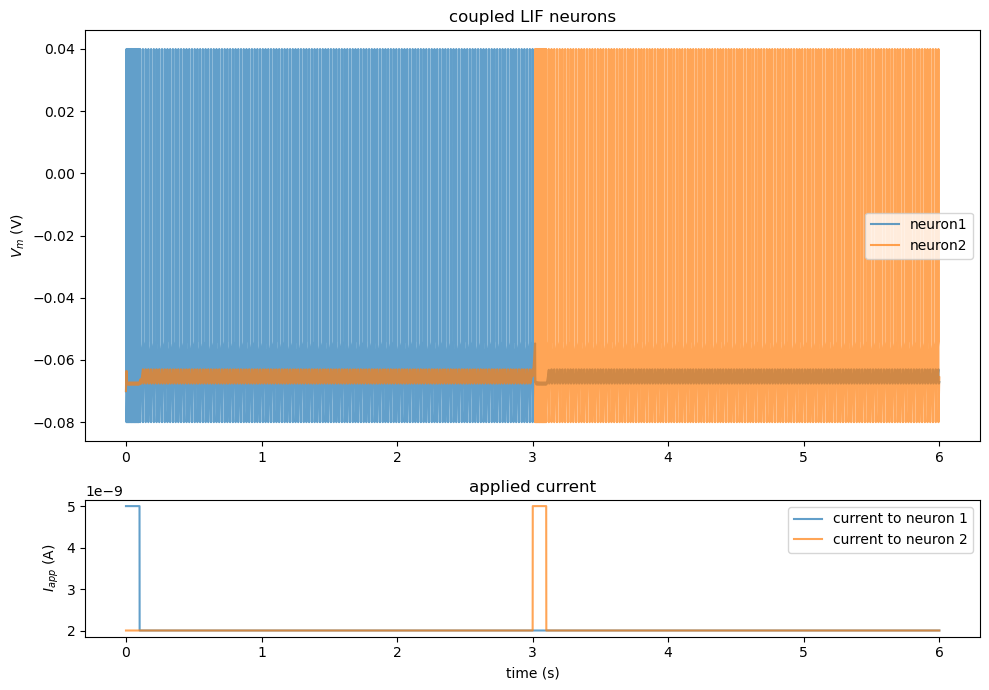

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(t, v1, alpha=0.7, label='neuron1')
ax[0].plot(t, v2, alpha=0.7, label='neuron2')
ax[0].set_title('coupled LIF neurons')
ax[0].set_ylabel('$V_m$ (V)')
ax[0].legend()

ax[1].plot(t, i_app_1, alpha=0.7, label='current to neuron 1')
ax[1].plot(t, i_app_2, alpha=0.7, label='current to neuron 2')
ax[1].set_title('applied current')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('$I_{app}$ (A)')
ax[1].legend()

plt.tight_layout()

### iii
- add noise by setting sigma = 5e-11
- rerun simulation with only baseline curent

In [44]:
i_app = np.ones_like(t) * i_app_baseline
v1, s1, v2, s2 = run_both(i_app, i_app, sigma=5e-11)

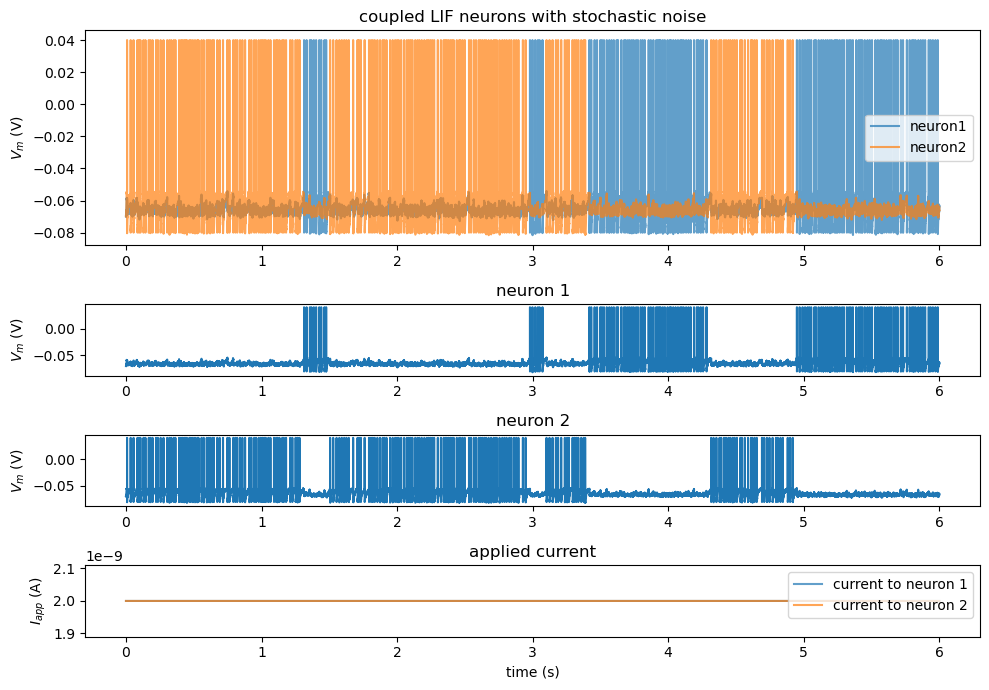

In [56]:
fig, ax = plt.subplots(4, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1, 1, 1]})

ax[0].plot(t, v1, alpha=0.7, label='neuron1')
ax[0].plot(t, v2, alpha=0.7, label='neuron2')
ax[0].set_title('coupled LIF neurons with stochastic noise')
ax[0].set_ylabel('$V_m$ (V)')
ax[0].legend()

ax[1].plot(t, v1)
ax[1].set_title('neuron 1')
ax[1].set_ylabel('$V_m$ (V)')

ax[2].plot(t, v2)
ax[2].set_title('neuron 2')
ax[2].set_ylabel('$V_m$ (V)')

ax[3].plot(t, i_app, alpha=0.7, label='current to neuron 1')
ax[3].plot(t, i_app, alpha=0.7, label='current to neuron 2')
ax[3].set_title('applied current')
ax[3].set_xlabel('time (s)')
ax[3].set_ylabel('$I_{app}$ (A)')
ax[3].legend()


plt.tight_layout()